In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def prepae_data():
    x, t = [], []

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((229, 229))
                img_np = np.array(img_resize) / 255.0
                img_reshape = img_np.reshape(1, 229, 229, 3)
                #print(datetime.datetime.now().isoformat(), img_np.shape, img_reshape.shape)

                x.append(img_np)
                t.append(category_id)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [3]:
x, t = prepae_data()

2020-06-02T12:41:21.890363 Category 0 : 117
2020-06-02T12:41:21.891151 Image: 0 1015 0
2020-06-02T12:41:22.129116 Image: 30 1228 0
2020-06-02T12:41:22.363708 Image: 60 1106 0
2020-06-02T12:41:22.596092 Image: 90 1129 0
2020-06-02T12:41:22.800867 Category 1 : 119
2020-06-02T12:41:22.801195 Image: 0 3636 1
2020-06-02T12:41:23.027391 Image: 30 3722 1
2020-06-02T12:41:23.252893 Image: 60 3832 1
2020-06-02T12:41:23.477947 Image: 90 3777 1
2020-06-02T12:41:23.692808 Category 2 : 129
2020-06-02T12:41:23.693456 Image: 0 3601 2
2020-06-02T12:41:23.933909 Image: 30 3884 2
2020-06-02T12:41:24.166555 Image: 60 3778 2
2020-06-02T12:41:24.397333 Image: 90 3853 2
2020-06-02T12:41:24.631036 Image: 120 1502 2
2020-06-02T12:41:24.698365 Category 3 : 111
2020-06-02T12:41:24.698779 Image: 0 3312 3
2020-06-02T12:41:24.925967 Image: 30 2350 3
2020-06-02T12:41:25.146526 Image: 60 3010 3
2020-06-02T12:41:25.376590 Image: 90 3105 3


In [4]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(476, 229, 229, 3) (476,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [7]:
print(x_train.shape, x_val.shape)

(333, 229, 229, 3) (143, 229, 229, 3)


In [0]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [9]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

In [0]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

In [12]:
reset_seed(0)

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
#model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)
#optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 27,685,740
Trainable params: 16,101,900
Non-trainable params: 11,583,840
___________________________________

In [14]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(x_train, t_train,
                    batch_size=30,
                    epochs=400,
                    verbose=0,
                    validation_data=(x_val, t_val))

print(datetime.datetime.now().isoformat(), 'End')

2020-06-02T12:43:28.510582 Start
2020-06-02T13:03:03.442459 End


In [0]:
results = pd.DataFrame(history.history)

In [16]:
results.head()

,loss,accuracy,val_loss,val_accuracy
0,4.223026,0.345345,1.343672,0.335664
1,1.338807,0.366366,1.348317,0.314685
2,1.277686,0.456456,1.364143,0.272727
3,1.164181,0.579580,1.364013,0.328671
4,1.065587,0.600601,1.362661,0.335664


In [17]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
395,0.006321,1.000000,2.829616,0.447552
396,0.004476,1.000000,2.769156,0.447552
397,0.006077,0.996997,2.710815,0.440559
398,0.008942,0.996997,2.674885,0.447552
399,0.013641,0.996997,2.666550,0.454545


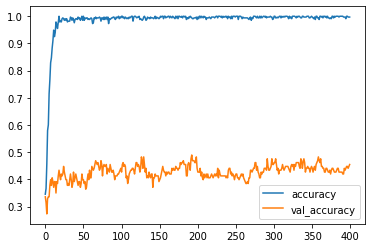

In [18]:
results[['accuracy', 'val_accuracy']].plot()

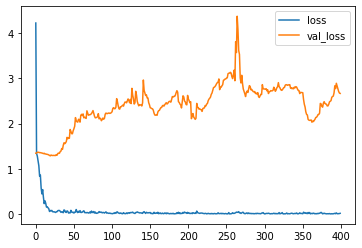

In [19]:
results[['loss', 'val_loss']].plot()